## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2, 0.5, 0.7]
redice_lr_patient = [5,20,50]

In [12]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """

    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 5s 100us/step - loss: 1.6007 - accuracy: 0.4415 - val_loss: 1.6788 - val_accuracy: 0.4074
Epoch 11/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.5791 - accuracy: 0.4493 - val_loss: 1.6663 - val_accuracy: 0.4162
Epoch 12/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.5590 - accuracy: 0.4559 - val_loss: 1.6542 - val_accuracy: 0.4214
Epoch 13/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.5416 - accuracy: 0.4619 - val_loss: 1.6477 - val_accuracy: 0.4246
Epoch 14/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.5241 - accuracy: 0.4678 - val_loss: 1.6385 - val_accuracy: 0.4267
Epoch 15/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.5086 - accuracy: 0.4734 - val_loss: 1.6328 - val_accuracy: 0.4286
Epoch 16/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.4930 - accuracy: 0.4811 - val_loss: 1.62

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 102us/step - loss: 2.6037 - accuracy: 0.1820 - val_loss: 2.2047 - val_accuracy: 0.1710
Epoch 2/25
50000/50000 [==============================] - 5s 103us/step - loss: 2.0787 - accuracy: 0.2974 - val_loss: 2.1209 - val_accuracy: 0.2278
Epoch 3/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.9207 - accuracy: 0.3384 - val_loss: 2.0287 - val_accuracy: 0.2713
Epoch 4/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.8343 - accuracy: 0.3662 - val_loss: 1.9597 - val_accuracy: 0.2971
Epoch 5/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.7747 - accuracy: 0.3818 - val_loss: 1.8731 - val_accuracy: 0.3352
Epoch 6/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.7312 - accuracy: 0.3955 - val_loss: 1.8147 - val_accuracy: 0.3587
Epoch 7/25
50000/50000 [==============================] - 5s 10

Epoch 21/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.4343 - accuracy: 0.5007 - val_loss: 1.5881 - val_accuracy: 0.4500
Epoch 22/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.4242 - accuracy: 0.5055 - val_loss: 1.5839 - val_accuracy: 0.4535
Epoch 23/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.4136 - accuracy: 0.5088 - val_loss: 1.5792 - val_accuracy: 0.4551
Epoch 24/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.4037 - accuracy: 0.5124 - val_loss: 1.5733 - val_accuracy: 0.4576
Epoch 25/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.3932 - accuracy: 0.5173 - val_loss: 1.5691 - val_accuracy: 0.4584
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 50
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)           

Epoch 6/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.7334 - accuracy: 0.3978 - val_loss: 1.7953 - val_accuracy: 0.3618
Epoch 7/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.6947 - accuracy: 0.4097 - val_loss: 1.7562 - val_accuracy: 0.3778
Epoch 8/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.6635 - accuracy: 0.4205 - val_loss: 1.7200 - val_accuracy: 0.3920
Epoch 9/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.6355 - accuracy: 0.4302 - val_loss: 1.6986 - val_accuracy: 0.4004
Epoch 10/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.6112 - accuracy: 0.4387 - val_loss: 1.6812 - val_accuracy: 0.4076
Epoch 11/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.5893 - accuracy: 0.4466 - val_loss: 1.6701 - val_accuracy: 0.4172
Epoch 12/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.5691 - accuracy: 0.4540 - val_loss

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_32 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128)               512

50000/50000 [==============================] - 5s 100us/step - loss: 0.8708 - accuracy: 0.7013 - val_loss: 1.4984 - val_accuracy: 0.4809
Epoch 12/25
50000/50000 [==============================] - 5s 101us/step - loss: 0.8158 - accuracy: 0.7240 - val_loss: 1.4068 - val_accuracy: 0.5049
Epoch 13/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.7888 - accuracy: 0.7356 - val_loss: 1.3874 - val_accuracy: 0.5153
Epoch 14/25
50000/50000 [==============================] - 5s 105us/step - loss: 0.7655 - accuracy: 0.7449 - val_loss: 1.3969 - val_accuracy: 0.5157
Epoch 15/25
50000/50000 [==============================] - 5s 95us/step - loss: 0.7433 - accuracy: 0.7534 - val_loss: 1.3888 - val_accuracy: 0.5206
Epoch 16/25
50000/50000 [==============================] - 5s 96us/step - loss: 0.7216 - accuracy: 0.7602 - val_loss: 1.4058 - val_accuracy: 0.5202
Epoch 17/25
50000/50000 [==============================] - 5s 104us/step - loss: 0.7001 - accuracy: 0.7709 - val_loss: 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 117us/step - loss: 2.1734 - accuracy: 0.2784 - val_loss: 2.1299 - val_accuracy: 0.2330
Epoch 2/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.8051 - accuracy: 0.3761 - val_loss: 2.0273 - val_accuracy: 0.2887
Epoch 3/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.7070 - accuracy: 0.4082 - val_loss: 1.9218 - val_accuracy: 0.3345
Epoch 4/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.6494 - accuracy: 0.4266 - val_loss: 1.8216 - val_accuracy: 0.3735
Epoch 5/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.6072 - accuracy: 0.4398 - val_loss: 1.7512 - val_accuracy: 0.3927
Epoch 6/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.5735 - accuracy: 0.4519 - val_loss: 1.7035 - val_accuracy: 0.4069
Epoch 7/25
50000/50000 [==============================] - 5s 1

50000/50000 [==============================] - 6s 111us/step - loss: 1.3569 - accuracy: 0.5328 - val_loss: 1.5557 - val_accuracy: 0.4588
Epoch 21/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.3473 - accuracy: 0.5368 - val_loss: 1.5509 - val_accuracy: 0.4606
Epoch 22/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.3380 - accuracy: 0.5409 - val_loss: 1.5500 - val_accuracy: 0.4627
Epoch 23/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.3282 - accuracy: 0.5437 - val_loss: 1.5430 - val_accuracy: 0.4629
Epoch 24/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.3198 - accuracy: 0.5488 - val_loss: 1.5424 - val_accuracy: 0.4639
Epoch 25/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.3109 - accuracy: 0.5504 - val_loss: 1.5363 - val_accuracy: 0.4660
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 20
Model: "model_16"
________________________________________

50000/50000 [==============================] - 8s 154us/step - loss: 1.6712 - accuracy: 0.4179 - val_loss: 1.8546 - val_accuracy: 0.3470
Epoch 5/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.6277 - accuracy: 0.4324 - val_loss: 1.7859 - val_accuracy: 0.3721
Epoch 6/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.5912 - accuracy: 0.4459 - val_loss: 1.7197 - val_accuracy: 0.3943
Epoch 7/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.5641 - accuracy: 0.4546 - val_loss: 1.6833 - val_accuracy: 0.4062
Epoch 8/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.5392 - accuracy: 0.4658 - val_loss: 1.6509 - val_accuracy: 0.4211
Epoch 9/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.5178 - accuracy: 0.4734 - val_loss: 1.6306 - val_accuracy: 0.42570s - loss: 1.5175 - ac
Epoch 10/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.4990 - accuracy: 0

Epoch 24/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.3110 - accuracy: 0.5484 - val_loss: 1.5401 - val_accuracy: 0.4632
Epoch 25/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.3021 - accuracy: 0.5497 - val_loss: 1.5307 - val_accuracy: 0.4667
Numbers of exp: 16, reduce_factor: 0.70, reduce_patient: 20
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_55 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
________________________________

50000/50000 [==============================] - 5s 105us/step - loss: 1.5342 - accuracy: 0.4672 - val_loss: 1.6535 - val_accuracy: 0.4184
Epoch 9/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.5111 - accuracy: 0.4758 - val_loss: 1.6236 - val_accuracy: 0.4315
Epoch 10/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.4919 - accuracy: 0.4837 - val_loss: 1.6181 - val_accuracy: 0.4357
Epoch 11/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.4750 - accuracy: 0.4900 - val_loss: 1.6076 - val_accuracy: 0.4379
Epoch 12/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.4591 - accuracy: 0.4951 - val_loss: 1.6042 - val_accuracy: 0.4399
Epoch 13/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.4442 - accuracy: 0.5002 - val_loss: 1.5982 - val_accuracy: 0.4425
Epoch 14/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.4308 - accuracy: 0.5044 - val_loss: 1.5943

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 99us/step - loss: 2.1096 - accuracy: 0.2800 - val_loss: 2.1253 - val_accuracy: 0.2183
Epoch 2/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.7838 - accuracy: 0.3740 - val_loss: 2.0029 - val_accuracy: 0.2815
Epoch 3/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.6620 - accuracy: 0.4156 - val_loss: 1.8645 - val_accuracy: 0.3587
Epoch 4/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.5817 - accuracy: 0.4459 - val_loss: 1.7819 - val_accuracy: 0.3810
Epoch 5/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.5217 - accuracy: 0.4658 - val_loss: 1.6978 - val_accuracy: 0.4015
Epoch 6/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.4705 - accuracy: 0.4854 - val_loss: 1.6382 - val_accuracy: 0.4239
Epoch 7/25
50000/50000 [==============================] - 4s 87us/st

Epoch 21/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.0660 - accuracy: 0.6405 - val_loss: 1.4852 - val_accuracy: 0.4896
Epoch 22/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.0472 - accuracy: 0.6479 - val_loss: 1.4943 - val_accuracy: 0.4895
Epoch 23/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.0290 - accuracy: 0.6538 - val_loss: 1.5154 - val_accuracy: 0.4779
Epoch 24/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.0102 - accuracy: 0.6627 - val_loss: 1.5169 - val_accuracy: 0.4765
Epoch 25/25
50000/50000 [==============================] - 5s 96us/step - loss: 0.9940 - accuracy: 0.6706 - val_loss: 1.5035 - val_accuracy: 0.4806
Numbers of exp: 21, reduce_factor: 0.50, reduce_patient: 5
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 3072)          

Epoch 6/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.4746 - accuracy: 0.4865 - val_loss: 1.6165 - val_accuracy: 0.4373
Epoch 7/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.4316 - accuracy: 0.5018 - val_loss: 1.5994 - val_accuracy: 0.4413
Epoch 8/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.3920 - accuracy: 0.5159 - val_loss: 1.5631 - val_accuracy: 0.4515
Epoch 9/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.3586 - accuracy: 0.5294 - val_loss: 1.5571 - val_accuracy: 0.4492
Epoch 10/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.3259 - accuracy: 0.5398 - val_loss: 1.5537 - val_accuracy: 0.4514
Epoch 11/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.2960 - accuracy: 0.5518 - val_loss: 1.5279 - val_accuracy: 0.4668
Epoch 12/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.2698 - accuracy: 0.5634 - val_los

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_79 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_80 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_81 (Batc (None, 128)               512

50000/50000 [==============================] - 5s 91us/step - loss: 1.4083 - accuracy: 0.5126 - val_loss: 1.5727 - val_accuracy: 0.4473
Epoch 11/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.3800 - accuracy: 0.5208 - val_loss: 1.5585 - val_accuracy: 0.4552
Epoch 12/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.3546 - accuracy: 0.5313 - val_loss: 1.5608 - val_accuracy: 0.4512
Epoch 13/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.3306 - accuracy: 0.5418 - val_loss: 1.5329 - val_accuracy: 0.4606
Epoch 14/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.3083 - accuracy: 0.5485 - val_loss: 1.5395 - val_accuracy: 0.4543
Epoch 15/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.2882 - accuracy: 0.5559 - val_loss: 1.5279 - val_accuracy: 0.4622
Epoch 16/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.2673 - accuracy: 0.5633 - val_loss: 1.5322

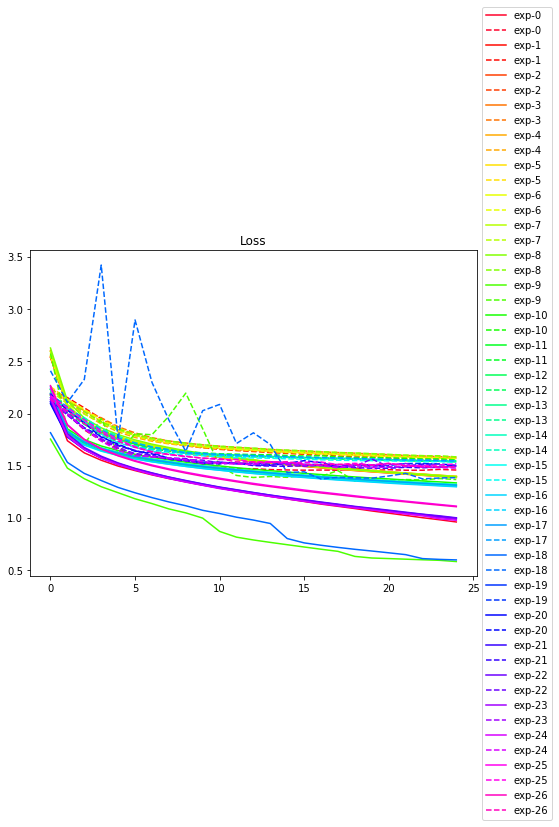

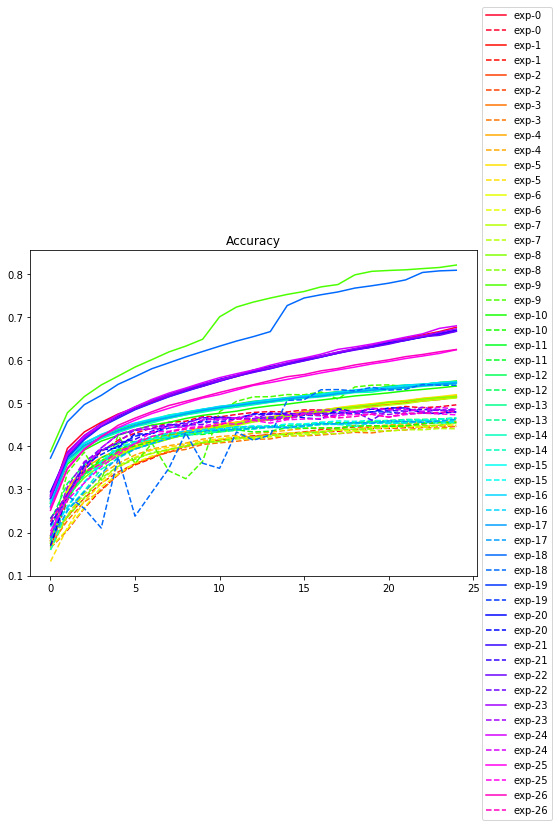

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()